In [ ]:
# Train the ISIC 2024 Data
#* Idea is to show how this works
#* This notebook will predicts on test using an average of all folds

In [1]:
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import binarize
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import GroupKFold
import os
import h5py
import io
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader
import timm
from tqdm import tqdm

# Setup

# Load environmental variables



In [ ]:
DATA = os.environ.get("DATA")
TRAIN_CSV = os.environ.get("TRAIN_CSV")
TEST_CSV = os.environ.get("TEST_CSV")
TRAIN_HDF5 = os.environ.get("TRAIN_HDF5")
TEST_HDF5 = os.environ.get("TEST_HDF5")
PRETRAINED_MODEL = os.environ.get("PRETRAINED_MODEL")

In [2]:
# Set up device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
#number of epochs to train for
num_epochs = 1

#train entire model vs. just the classifier
freeze_base_model = False  #didn't get good results

# if this is set to true - full model is only generated as part of scoring (quick_train_record_count used)
# this saves GPU quota - but saved model won't reflect what was scored...
full_train_only_when_scoring = False  #must be False to save full model!
quick_train_record_count = 50000   #need to get at least some positive cases even for test run

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Number of GPUs: 1


# Load meta - and split folds
* Maintain consistency with tabular data in other notebooks

In [3]:
df_train = pd.read_csv(TRAIN_CSV)

num_folds = 5

gkf = GroupKFold(n_splits=num_folds)

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

# Add summary
fold_summary = df_train.groupby("fold")["patient_id"].nunique().to_dict()
total_patients = df_train["patient_id"].nunique()

print(f"Fold Summary (patients per fold):")
for fold, count in fold_summary.items():
    if fold != -1:  # Exclude the initialization value
        print(f"Fold {fold}: {count} patients")
print(f"Total patients: {total_patients}")

/tmp/ipykernel_24/3044158870.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")


Fold Summary (patients per fold):
Fold 0: 206 patients
Fold 1: 209 patients
Fold 2: 208 patients
Fold 3: 209 patients
Fold 4: 210 patients
Total patients: 1042


# Load meta data / review

In [4]:
# Set the HDF5 file path
TRAIN_HDF5_FILE_PATH = TRAIN_HDF5

# are we scoring?
scoring = False
#check length of test data to see if we are scoring....
test_length = len(pd.read_csv(TEST_CSV))
if test_length > 3:
    scoring = True

if not scoring:
    if full_train_only_when_scoring:
        df_train = df_train.head(quick_train_record_count)
                
print("\nOriginal Dataset Summary:")
print(f"Total number of samples: {len(df_train)}")
print(f"Number of unique patients: {df_train['patient_id'].nunique()}")

original_positive_cases = df_train['target'].sum()
original_total_cases = len(df_train)
original_positive_ratio = original_positive_cases / original_total_cases

print(f"Number of positive cases: {original_positive_cases}")
print(f"Number of negative cases: {original_total_cases - original_positive_cases}")
print(f"Ratio of negative to positive cases: {(original_total_cases - original_positive_cases) / original_positive_cases:.2f}:1")


Original Dataset Summary:
Total number of samples: 401059
Number of unique patients: 1042
Number of positive cases: 393
Number of negative cases: 400666
Ratio of negative to positive cases: 1019.51:1


# Downsample Negatives / Keep All Positives
* Keeping just 1% of negatives!
* We only use a small subset of the data in each fold for training...

In [5]:
#keep all positives
df_target_1 = df_train[df_train['target'] == 1]

#just use 1% of negatives
df_target_0 = df_train[df_train['target'] == 0].sample(frac=0.01, random_state=42)

df_train_balanced = pd.concat([df_target_1, df_target_0]).reset_index(drop=True)

# Print balanced dataset summary
print("Balanced Dataset Summary:")
print(f"Total number of samples: {len(df_train)}")
print(f"Number of unique patients: {df_train['patient_id'].nunique()}")

positive_cases = df_train_balanced['target'].sum()
total_cases = len(df_train_balanced)
positive_ratio = positive_cases / total_cases

print(f"Number of positive cases: {positive_cases}")
print(f"Number of negative cases: {total_cases - positive_cases}")
print(f"New ratio of negative to positive cases: {(total_cases - positive_cases) / positive_cases:.2f}:1")

Balanced Dataset Summary:
Total number of samples: 401059
Number of unique patients: 1042
Number of positive cases: 393
Number of negative cases: 4007
New ratio of negative to positive cases: 10.20:1


# ImageNet Setup for Training

In [1]:
def setup_model(num_classes=2, freeze_base_model=freeze_base_model):
    model = timm.create_model('tf_efficientnetv2_b1', 
                            checkpoint_path=PRETRAINED_MODEL,
                            pretrained=False)

    if freeze_base_model:
        for param in model.parameters():
            param.requires_grad = False

    model.classifier = nn.Linear(model.classifier.in_features, out_features=num_classes)
    return model.to(device)    

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

NameError: name 'freeze_base_model' is not defined

# Data Loading / Image Augmentation

In [7]:
class ISICDataset(Dataset):
    def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
        self.hdf5_file = hdf5_file
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_file, 'r') as f:
            img_bytes = f[self.isic_ids[idx]][()]
        
        img = Image.open(io.BytesIO(img_bytes))
        img = np.array(img)  # Convert PIL Image to numpy array
        
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
        
        if self.targets is not None:
            target = self.targets[idx]
        else:
            target = torch.tensor(-1)  # Dummy target for test set
            
        return img, target
    
# Prepare augmentation
aug_transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.1, p=0.5),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Visualize image augmentation

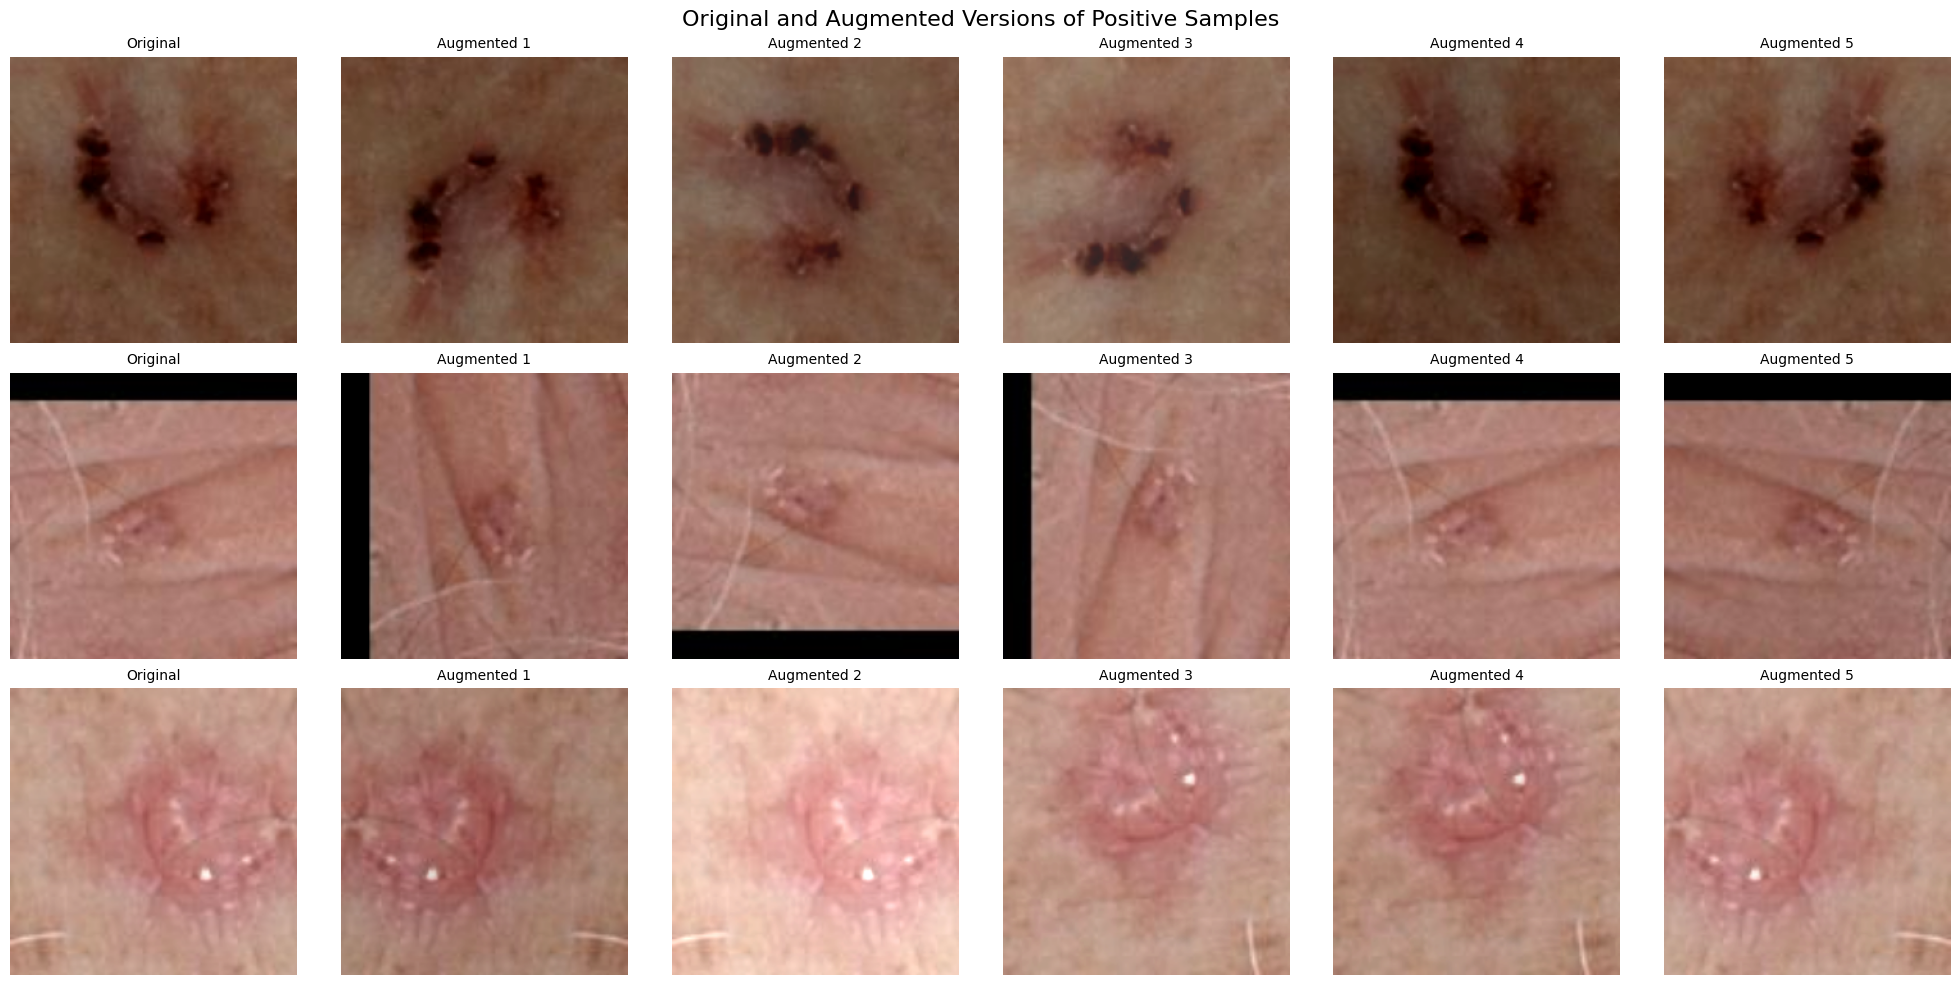

In [8]:
import matplotlib.pyplot as plt


def visualize_augmentations_positive(dataset, num_samples=3, num_augmentations=5, figsize=(20, 10)):
    # Find positive samples
    positive_samples = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label == 1:  # Assuming 1 is the positive class
            positive_samples.append(i)

        if len(positive_samples) == num_samples:
            break
    
    if len(positive_samples) < num_samples:
        print(f"Warning: Only found {len(positive_samples)} positive samples.")
    
    fig, axes = plt.subplots(num_samples, num_augmentations + 1, figsize=figsize)
    fig.suptitle("Original and Augmented Versions of Positive Samples", fontsize=16)

    for sample_num, sample_idx in enumerate(positive_samples):
        # Get a single sample
        original_image, label = dataset[sample_idx]
        
        # If the image is already a tensor (due to ToTensorV2 in the transform), convert it back to numpy
        if isinstance(original_image, torch.Tensor):
            original_image = original_image.permute(1, 2, 0).numpy()
            
        # Reverse the normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        original_image = (original_image * std + mean) * 255
        original_image = original_image.astype(np.uint8)

        # Display original image
        axes[sample_num, 0].imshow(original_image)
        axes[sample_num, 0].axis('off')
        axes[sample_num, 0].set_title("Original", fontsize=10)

        # Apply and display augmentations
        for aug_num in range(num_augmentations):
            augmented = dataset.transform(image=original_image)['image']
            # If the result is a tensor, convert it back to numpy
            if isinstance(augmented, torch.Tensor):
                augmented = augmented.permute(1, 2, 0).numpy()
            # Reverse the normalization
            augmented = (augmented * std + mean) * 255
            augmented = augmented.astype(np.uint8)
            
            axes[sample_num, aug_num + 1].imshow(augmented)
            axes[sample_num, aug_num + 1].axis('off')
            axes[sample_num, aug_num + 1].set_title(f"Augmented {aug_num + 1}", fontsize=10)

    plt.tight_layout()
    plt.show()
    
augtest_dataset = ISICDataset(
    hdf5_file=TRAIN_HDF5_FILE_PATH,
    isic_ids=df_train['isic_id'].values,
    targets=df_train['target'].values,
    transform=aug_transform,
)

visualize_augmentations_positive(augtest_dataset)

# Scoring code from https://www.kaggle.com/code/metric/isic-pauc-abovetpr

In [9]:
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return(partial_auc)

# Train / CV

In [10]:
import torch
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
import numpy as np

def train_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, fold, epoch, device):
    scaler = GradScaler()
    
    # Training phase
    model.train()
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}, Fold {fold+1} Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Evaluation phase
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad(), autocast():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}, Fold {fold+1} Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_targets.append(targets.cpu())
            val_outputs.append(outputs.softmax(dim=1)[:, 1].cpu())
    
    scheduler.step()
    return torch.cat(val_targets).numpy(), torch.cat(val_outputs).numpy()


def cross_validation_train(df_train, num_folds, num_epochs, hdf5_file_path, aug_transform, base_transform, device):
    criterion = nn.CrossEntropyLoss()
    all_val_targets, all_val_outputs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        epoch_val_targets, epoch_val_outputs = [], []

        for fold in range(num_folds):
            print(f"\nFold {fold + 1}/{num_folds}")
            
            # Split data for current fold
            train_df = df_train[df_train['fold'] != fold]
            val_df = df_train[df_train['fold'] == fold]
            
            # Create datasets and data loaders
            train_dataset = ISICDataset(hdf5_file_path, train_df['isic_id'].values, train_df['target'].values, aug_transform)
            val_dataset = ISICDataset(hdf5_file_path, val_df['isic_id'].values, val_df['target'].values, base_transform)
            
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
            
            # Initialize model, optimizer, and scheduler
            model = setup_model().to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
            
            print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, "
                  f"Train Pos Ratio: {train_df['target'].mean():.2%}, Val Pos Ratio: {val_df['target'].mean():.2%}")
            
            # Train and evaluate
            val_targets, val_outputs = train_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, fold, epoch, device)
            epoch_val_targets.extend(val_targets)
            epoch_val_outputs.extend(val_outputs)
            
            torch.save(model.state_dict(), f'model_fold_{fold}_epoch_{epoch + 1}.pth')
            
            # Create DataFrames with row_id for scoring
            solution_df = pd.DataFrame({'target': val_targets, 'row_id': range(len(val_targets))})
            submission_df = pd.DataFrame({'prediction': val_outputs, 'row_id': range(len(val_outputs))})
            fold_score = score(solution_df, submission_df, 'row_id')
            print(f'Fold {fold + 1} pAUC Score: {fold_score:.4f}')
        
        all_val_targets.extend(epoch_val_targets)
        all_val_outputs.extend(epoch_val_outputs)
        
        # Create DataFrames with row_id for scoring
        solution_df = pd.DataFrame({'target': epoch_val_targets, 'row_id': range(len(epoch_val_targets))})
        submission_df = pd.DataFrame({'prediction': epoch_val_outputs, 'row_id': range(len(epoch_val_outputs))})
        cv_score = score(solution_df, submission_df, 'row_id')
        print(f'Epoch {epoch + 1}/{num_epochs} CV pAUC Score: {cv_score:.4f}')

    return np.array(all_val_targets), np.array(all_val_outputs)

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Perform cross-validation training
all_val_targets, all_val_outputs = cross_validation_train(df_train_balanced, num_folds, num_epochs, TRAIN_HDF5_FILE_PATH, aug_transform, base_transform, device)

Using device: cuda

Epoch 1/1

Fold 1/5
Train: 3548, Val: 852, Train Pos Ratio: 8.54%, Val Pos Ratio: 10.56%


Epoch 1, Fold 1 Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.64s/it]


Fold 1 pAUC Score: 0.1223

Fold 2/5
Train: 3492, Val: 908, Train Pos Ratio: 8.73%, Val Pos Ratio: 9.69%


Epoch 1, Fold 2 Evaluating: 100%|██████████| 4/4 [00:21<00:00,  5.45s/it]


Fold 2 pAUC Score: 0.1095

Fold 3/5
Train: 3514, Val: 886, Train Pos Ratio: 9.33%, Val Pos Ratio: 7.34%


Epoch 1, Fold 3 Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.51s/it]


Fold 3 pAUC Score: 0.1116

Fold 4/5
Train: 3510, Val: 890, Train Pos Ratio: 8.89%, Val Pos Ratio: 9.10%


Epoch 1, Fold 4 Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.59s/it]


Fold 4 pAUC Score: 0.0828

Fold 5/5
Train: 3536, Val: 864, Train Pos Ratio: 9.16%, Val Pos Ratio: 7.99%


Epoch 1, Fold 5 Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.68s/it]


Fold 5 pAUC Score: 0.0599
Epoch 1/1 CV pAUC Score: 0.0881


In [11]:
# Final overall evaluation
print("\nFinal Overall Evaluation:")

# Calculate the official pAUC score
solution_df = pd.DataFrame({'target': all_val_targets, 'row_id': range(len(all_val_targets))})
submission_df = pd.DataFrame({'prediction': all_val_outputs, 'row_id': range(len(all_val_outputs))})
official_score = score(solution_df, submission_df, 'row_id')
print(f'Overall pAUC Score: {official_score:.4f}')

# Generate and print classification report
binary_predictions = binarize(np.array(all_val_outputs).reshape(-1, 1), threshold=0.5).reshape(-1)
report = classification_report(all_val_targets, binary_predictions, target_names=['Class 0', 'Class 1'])
print("\nOverall Classification Report:")
print(report)

# Print specific metrics for Class 1
report_dict = classification_report(all_val_targets, binary_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)
print(f"\nClass 1 Metrics:")
print(f"Precision: {report_dict['Class 1']['precision']:.4f}")
print(f"Recall: {report_dict['Class 1']['recall']:.4f}")
print(f"F1-score: {report_dict['Class 1']['f1-score']:.4f}")


Final Overall Evaluation:
Overall pAUC Score: 0.0881

Overall Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.97      0.95      4007
     Class 1       0.50      0.30      0.38       393

    accuracy                           0.91      4400
   macro avg       0.71      0.64      0.66      4400
weighted avg       0.89      0.91      0.90      4400


Class 1 Metrics:
Precision: 0.4958
Recall: 0.3028
F1-score: 0.3760


# Inference Code


In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import h5py
import timm
from PIL import Image
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2

epoch_for_preds = num_epochs
model_path = ""

class ISICDataset(Dataset):
    def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
        self.hdf5_file = h5py.File(hdf5_file, 'r')  # Keep file open
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        img_bytes = self.hdf5_file[self.isic_ids[idx]][()]
        img = Image.open(io.BytesIO(img_bytes))
        img = np.array(img)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']

        target = self.targets[idx] if self.targets is not None else torch.tensor(-1)
        return img, target

    def __del__(self):
        self.hdf5_file.close()  # Ensure file is closed when object is destroyed

# Define the albumentations transformation
base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

def setup_model(num_classes=2):
    return timm.create_model('tf_efficientnetv2_b1', pretrained=False, num_classes=num_classes)

def load_models(folds, device):
    models = []
    for fold in folds:
        model = setup_model().to(device)
        model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds}.pth', map_location=device))
        model.eval()
        models.append(model)
    return models

@torch.no_grad()  # Apply no_grad to the entire function
def ensemble_predict(models, test_loader, device):
    all_predictions = []
    for inputs, _ in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        fold_predictions = torch.stack([model(inputs).softmax(dim=1)[:, 1] for model in models])
        avg_predictions = fold_predictions.mean(dim=0)
        all_predictions.extend(avg_predictions.cpu().numpy())
    return all_predictions


# Generate out-of-fold predictions for Train


In [13]:
def generate_oof_predictions(df_train, folds, hdf5_file_path, transform):
    oof_predictions = np.zeros(len(df_train))
    model_filenames = [''] * len(df_train)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    models = load_models(folds, device)

    for fold in folds:
        print(f"Generating predictions for fold {fold + 1}/{num_folds}")
        val_df = df_train[df_train['fold'] == fold].copy()
        val_dataset = ISICDataset(hdf5_file_path, val_df['isic_id'].values, val_df['target'].values, transform)
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)
        
        fold_predictions = ensemble_predict([models[fold]], val_loader, device)
        
        oof_predictions[val_df.index] = fold_predictions
        model_filename = f'model_fold_{fold}_epoch_1.pth'
        for idx in val_df.index:
            model_filenames[idx] = model_filename

    return oof_predictions, model_filenames


if not scoring:
    # Set up CUDA if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the number of folds
    folds = [0, 1, 2, 3, 4]

    # Generate out-of-fold predictions
    oof_predictions, model_filenames = generate_oof_predictions(df_train, folds, TRAIN_HDF5_FILE_PATH, base_transform)

    # Create DataFrame for OOF predictions
    oof_df = pd.DataFrame({
        'isic_id': df_train['isic_id'],
        'target': df_train['target'],
        'fold': df_train['fold'],
        'oof_prediction': oof_predictions,
        'model_filename': model_filenames
    })

    # Save OOF predictions to CSV
    oof_df.to_csv('oof_predictions.csv', index=False)
    print("Out-of-fold predictions saved to oof_predictions.csv")
    print(oof_df.head())

Using device: cuda
Generating predictions for fold 1/5


Predicting: 100%|██████████| 157/157 [01:35<00:00,  1.65it/s]


Generating predictions for fold 2/5


Predicting: 100%|██████████| 157/157 [01:25<00:00,  1.83it/s]


Generating predictions for fold 3/5


Predicting: 100%|██████████| 157/157 [01:25<00:00,  1.84it/s]


Generating predictions for fold 4/5


Predicting: 100%|██████████| 157/157 [01:23<00:00,  1.88it/s]


Generating predictions for fold 5/5


Predicting: 100%|██████████| 157/157 [01:24<00:00,  1.86it/s]


Out-of-fold predictions saved to oof_predictions.csv
        isic_id  target  fold  oof_prediction            model_filename
0  ISIC_0015670       0     3        0.028122  model_fold_3_epoch_1.pth
1  ISIC_0015845       0     1        0.371496  model_fold_1_epoch_1.pth
2  ISIC_0015864       0     4        0.001162  model_fold_4_epoch_1.pth
3  ISIC_0015902       0     1        0.000305  model_fold_1_epoch_1.pth
4  ISIC_0024200       0     0        0.030375  model_fold_0_epoch_1.pth


# Predict for test

In [14]:
df_test = pd.read_csv(TEST_CSV)
TEST_HDF5_FILE_PATH = TEST_HDF5

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# folds to use for pred
folds = [0, 1, 2, 3, 4]

models = load_models(folds, device)

# Prepare your test dataset
test_dataset = ISICDataset(
    hdf5_file=TEST_HDF5_FILE_PATH,
    isic_ids=df_test['isic_id'].values,
    transform=base_transform,
)    

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

# Run predictions
predictions = ensemble_predict(models, test_loader, device)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'isic_id': df_test['isic_id'],
    'target': predictions
})

# Save predictions to CSV
submission_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")
print(submission_df.head())

Using device: cuda


Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

Predictions saved to submission.csv
        isic_id    target
0  ISIC_0015657  0.057628
1  ISIC_0015729  0.003957
2  ISIC_0015740  0.097699
